# Lab 9

Nathan Martindale  
Jacob Smith

#### Read in a CSV file in which the last column is the target class. (You can start by using the spambase.csv file.)

In [36]:
import numpy as np
import pandas as pd

data = pd.read_csv("spambase.csv")

#### Transform data as necessary

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

# set up X (variables)
X = data
X = X.drop(data.columns[-1], axis=1) # drop the last column

# reshape it as necessary
X = np.ravel(X).reshape(X.shape[0], X.shape[1])

# set y as the target column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(data[data.columns[-1]])

# flatten y into a 1-D array
y = np.ravel(y_df)

# split the data into training data and test data (20/80 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=4)

#### 10-Fold Cross-Validation on unpruned decision tree

In [38]:
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import roc_curve, auc

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=4)

accuracies = []
aucs = []

for train_index, test_index in kf.split(X_test):
    
    X_train_cv = X_test[train_index]
    y_train_cv = y_test[train_index]
    
    X_test_cv = X_test[test_index]
    y_test_cv = y_test[test_index]
    
    # create the tree classifier
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

Average:  0.917950983858
AUC:  0.916452035153


#### Cross-validation to select best pruning level

In [39]:
# initialize best_pruning_level to infinity
best_pruning_level = 0
best_score = 0

# cycle through pruning levels
for i in range(5, 50):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    accuracies = []
    
    for train_index, test_index in kf.split(X_train):
        X_train_cv = X_train[train_index]
        y_train_cv = y_train[train_index]

        X_test_cv = X_train[test_index]
        y_test_cv = y_train[test_index]

        # fit the tree classifier
        clf = clf.fit(X_train_cv, y_train_cv)

        # see how well it does
        predicted = clf.predict(X_test_cv)
        score = np.mean(predicted == y_test_cv)
        accuracies.append(score)
        
    avg_score = sum(accuracies) / len(accuracies)
    print(i, " - ", avg_score)
    if avg_score > best_score:
        best_score = avg_score
        best_pruning_level = i

print("Best pruning level: ", best_pruning_level)

5  -  0.888043478261
6  -  0.891304347826
7  -  0.880434782609
8  -  0.890217391304
9  -  0.896739130435
10  -  0.883695652174
11  -  0.886956521739
12  -  0.885869565217
13  -  0.883695652174
14  -  0.889130434783
15  -  0.878260869565
16  -  0.880434782609
17  -  0.890217391304
18  -  0.876086956522
19  -  0.885869565217
20  -  0.880434782609
21  -  0.873913043478
22  -  0.880434782609
23  -  0.872826086957
24  -  0.878260869565
25  -  0.886956521739
26  -  0.878260869565
27  -  0.88152173913
28  -  0.883695652174
29  -  0.884782608696
30  -  0.888043478261
31  -  0.889130434783
32  -  0.884782608696
33  -  0.882608695652
34  -  0.879347826087
35  -  0.880434782609
36  -  0.875
37  -  0.88152173913
38  -  0.878260869565
39  -  0.870652173913
40  -  0.884782608696
41  -  0.880434782609
42  -  0.883695652174
43  -  0.885869565217
44  -  0.877173913043
45  -  0.880434782609
46  -  0.873913043478
47  -  0.879347826087
48  -  0.880434782609
49  -  0.88152173913
Best pruning level:  9


#### Cross-validation on pruned decision tree

In [40]:
accuracies = []
aucs = []

for train_index, test_index in kf.split(X_test):
    
    X_train_cv = X_test[train_index]
    y_train_cv = y_test[train_index]
    
    X_test_cv = X_test[test_index]
    y_test_cv = y_test[test_index]
    
    # create the tree classifier
    clf = tree.DecisionTreeClassifier(max_depth=best_pruning_level)
    clf = clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)
    
pdt_probs = clf.predict_proba(X_test)[:,1]
    
    
# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

Average:  0.924478614351
AUC:  0.925975931582


#### Generate and evaluate 50 bagged decision trees

In [41]:
from sklearn.ensemble import BaggingClassifier

accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    # create the tree classifier
    clf = BaggingClassifier(n_estimators=50)
    clf = clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)
    

bagc_probs = clf.predict_proba(X_test)[:,1]

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

0.930585683297
0.947826086957
0.954347826087
0.941304347826
0.95
0.95652173913
0.941304347826
0.945652173913
0.952173913043
0.941304347826
Average:  0.946102046591
AUC:  0.978398199966


#### Generate and evaluate 50 boosted decision trees

In [42]:
from sklearn.ensemble import AdaBoostClassifier

accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    # create the tree classifier
    clf = AdaBoostClassifier(n_estimators=50)
    clf = clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)
    
boostc_probs = clf.predict_proba(X_test)[:,1]

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

0.9284164859
0.95652173913
0.936956521739
0.926086956522
0.94347826087
0.952173913043
0.932608695652
0.939130434783
0.932608695652
0.930434782609
Average:  0.93784164859
AUC:  0.979456953551


#### Generate and evaluate random forest (100 trees)

In [43]:
from sklearn.ensemble import RandomForestClassifier

accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    # create the tree classifier
    clf = RandomForestClassifier(n_estimators=100)
    clf = clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)
    
rf_probs = clf.predict_proba(X_test)[:,1]

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

0.945770065076
0.954347826087
0.95652173913
0.952173913043
0.952173913043
0.969565217391
0.94347826087
0.954347826087
0.963043478261
0.945652173913
Average:  0.95370744129
AUC:  0.986356647159


#### Plot the classifiers

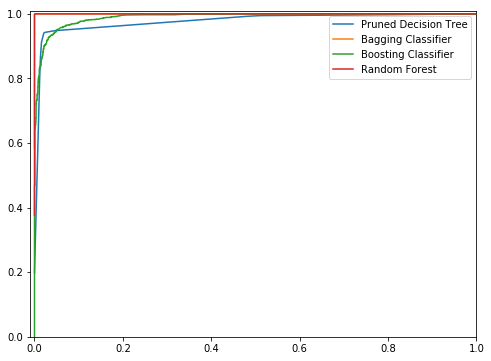

In [44]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pdt_fpr, pdt_tpr, pdt_thresholds = roc_curve(y_test, pdt_probs)
bagc_fpr, bagc_tpr, bagc_thresholds = roc_curve(y_test, bagc_probs)
boostc_fpr, boostc_tpr, boostc_thresholds = roc_curve(y_test, boostc_probs)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)


plt.figure(figsize=(8,6))
plt.plot(pdt_fpr, pdt_tpr, label='Pruned Decision Tree')
plt.plot(bagc_fpr, bagc_tpr, label='Bagging Classifier')
plt.plot(boostc_fpr, boostc_tpr, label='Boosting Classifier')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlim([-.01,1])
plt.ylim([0,1.01])
plt.legend()
plt.show()

#### Create NN with same number of hidden neurons as inputs

In [45]:
from sklearn.neural_network import MLPClassifier


accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    
    # same number of neurons in the hidden layer
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(X.shape[1]), random_state=4)
    clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)


0.90021691974
0.889130434783
0.934782608696
0.917391304348
0.921739130435
0.921739130435
0.921739130435
0.930434782609
0.9
0.908695652174
Average:  0.914586909365
AUC:  0.966187245828


#### Create NN with double the number of hidden neurons

In [46]:
accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    
    # same number of neurons in the hidden layer
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(X.shape[1]*2), random_state=4)
    clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)


0.882863340564
0.847826086957
0.932608695652
0.891304347826
0.89347826087
0.932608695652
0.869565217391
0.884782608696
0.867391304348
0.919565217391
Average:  0.892199377535
AUC:  0.955510929548


#### Create NN with half the number of hidden neurons

In [47]:
from sklearn.neural_network import MLPClassifier


accuracies = []
aucs = []

for train_index, test_index in kf.split(X):
    
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]
    
    X_test_cv = X[test_index]
    y_test_cv = y[test_index]
    
    
    # same number of neurons in the hidden layer
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(int(X.shape[1]/2)), random_state=4)
    clf.fit(X_train_cv, y_train_cv)
    
    # see how well it does
    predicted = clf.predict(X_test_cv)
    score = np.mean(predicted == y_test_cv)
    print(score)
    accuracies.append(score)
    
    # get auc
    probs = clf.predict_proba(X_test_cv)[:,1]
    fpr, tpr, thres = roc_curve(y_test_cv, probs)
    cur_auc = auc(fpr, tpr)
    aucs.append(cur_auc)

# average results
cv_accuracy = sum(accuracies) / len(accuracies)
print("Average: ", cv_accuracy)
auc_avg = sum(aucs) / len(aucs)
print("AUC: ", auc_avg)

0.904555314534
0.936956521739
0.923913043478
0.919565217391
0.915217391304
0.928260869565
0.917391304348
0.917391304348
0.926086956522
0.908695652174
Average:  0.91980335754
AUC:  0.968748505253


## Problem Description

We are given a data set containing a few dozen features about emails, such as the the frequency of the word money, the number of consecutive capital letters, or the frequency of the name George, and a label defining whether that email is spam or not. Our goal is to have the ability to reliably determine whether new email instances are spam based on this set of features.

## Techniques

We ran experiments utilizing unpruned and pruned decision trees, decision trees with bagging and boosting, random forests, and neural networks of varying architectures. For every experiment, we ran 10-fold cross-validation, in order to reliably determine accuracy without overfitting. We also used 10-fold cross-validation to select which maximum depth was best for our pruned decision tree model. Values between 5 and 50 were tested, and we found that pruning depths on the lower end tended to work better.

For every experiment, accuracy and area under the curve were calculated, and used for determining which model is best.

## Results

In comparing the results of all of the different classifiers tested, we found that using a random forest had the highest accuracy, at 95.4%. Interestingly, the decision trees and related classifiers all did better than neural networks did, for this particular problem. 

In trying to design an efficient spam filter then, random forests would be the best option to expand for further fine-tuning.


Pruned Decision Tree:  
92.4

Bagging:  
94.6

Boost:  
93.8

Random Forest:  
95.4

Neural Networks:  
91.5  
89.2  
92.0  